# Tabular Variational Autoencoder (TVAE)

El TVAE (Tabular Variational Autoencoder) es otro método avanzado de inteligencia artificial para generar datos sintéticos realísticos que combina redes neuronales con principios estadísticos. En esencia, funciona como un sistema de compresión y reconstrucción inteligente: primero, un "*encoder*" reduce los datos originales a una representación compacta llamada "espacio latente", donde se capturan las características esenciales de la información. Luego, un "*decoder*" utiliza esta representación para recrear los datos originales o generar nuevas muestras sintéticas. Lo que diferencia al TVAE de métodos más simples es que este espacio latente no es caótico, sino que sigue una distribución gaussiana controlada, lo que permite generar datos variados pero coherentes con la estructura original.

Matemáticamente, el TVAE se basa en el concepto de "inferencia variacional", que busca aproximar distribuciones complejas de datos mediante modelos probabilísticos. Durante el entrenamiento, el sistema no solo aprende a reconstruir datos, sino que también minimiza la divergencia entre la distribución del espacio latente y una distribución gaussiana estándar. Esto se logra mediante una función de pérdida que balancea dos objetivos: la precisión en la reconstrucción (para que los datos sintéticos se parezcan a los reales) y la regularización (para que el espacio latente mantenga una estructura estadística ordenada). Este equilibrio evita que el modelo genere datos idénticos a los originales o, por el contrario, produzca información sin sentido.

Para adaptarse específicamente a datos tabulares (como es en nuestro caso), el TVAE incorpora transformaciones especializadas. Así, las variables continuas se modelan como mezclas de distribuciones gaussianas, lo que permite capturar multimodalidad (varios picos en los datos), mientras que las variables categóricas se procesan con codificaciones que preservan sus relaciones. Esta flexibilidad permite al TVAE manejar relaciones no lineales y complejas entre variables, como las típicas en datos biológicos, donde métodos tradicionales basados en correlaciones lineales resultan insuficientes.

La principal ventaja del TVAE frente a métodos como Gaussian Copula radica en su capacidad para aprender patrones intrincados sin depender de suposiciones simplificadas sobre la estructura de los datos. Sin embargo, requiere mayor poder computacional y ajuste fino de hiperparámetros (como la dimensión del espacio latente o el peso de la regularización). Por esto, es ideal para casos donde la calidad de los datos sintéticos es crítica, como en investigación médica o biológica [[Jordon et al., 2022]](https://doi.org/10.48550/arXiv.2205.03257), donde preservar la complejidad de las distribuciones originales es esencial para validaciones posteriores. Su fundamento matemático lo convierte en una herramienta robusta para expandir conjuntos de datos limitados manteniendo la consistencia estadística de la población original.

Metadatos cargados desde JSON.
Inicializando TVAE...
Entrenando TVAE (esto puede tomar varios minutos)...
Generando datos sintéticos...


,Peso (g),Longitud (cm),Anchura (cm),Altura (cm)
0,7.32,8.0,2.8,0.6
1,3.09,5.1,2.1,0.4
2,2.60,6.8,2.9,0.4
3,3.89,8.1,3.1,0.5
4,9.47,10.4,3.5,0.6
5,3.45,6.5,2.2,0.4
6,3.35,6.2,2.8,0.4
7,9.76,8.0,2.5,0.4
8,7.58,8.3,3.0,0.5
9,3.45,6.6,2.1,0.4


Se muestran 10 primeros registros sintéticos TVAE de un total de 500

DIAGNÓSTICO BÁSICO CALIDAD DATOS

          Column             Metric  Score
0       Peso (g)  BoundaryAdherence    1.0
1  Longitud (cm)  BoundaryAdherence    1.0
2   Anchura (cm)  BoundaryAdherence    1.0
3    Altura (cm)  BoundaryAdherence    1.0


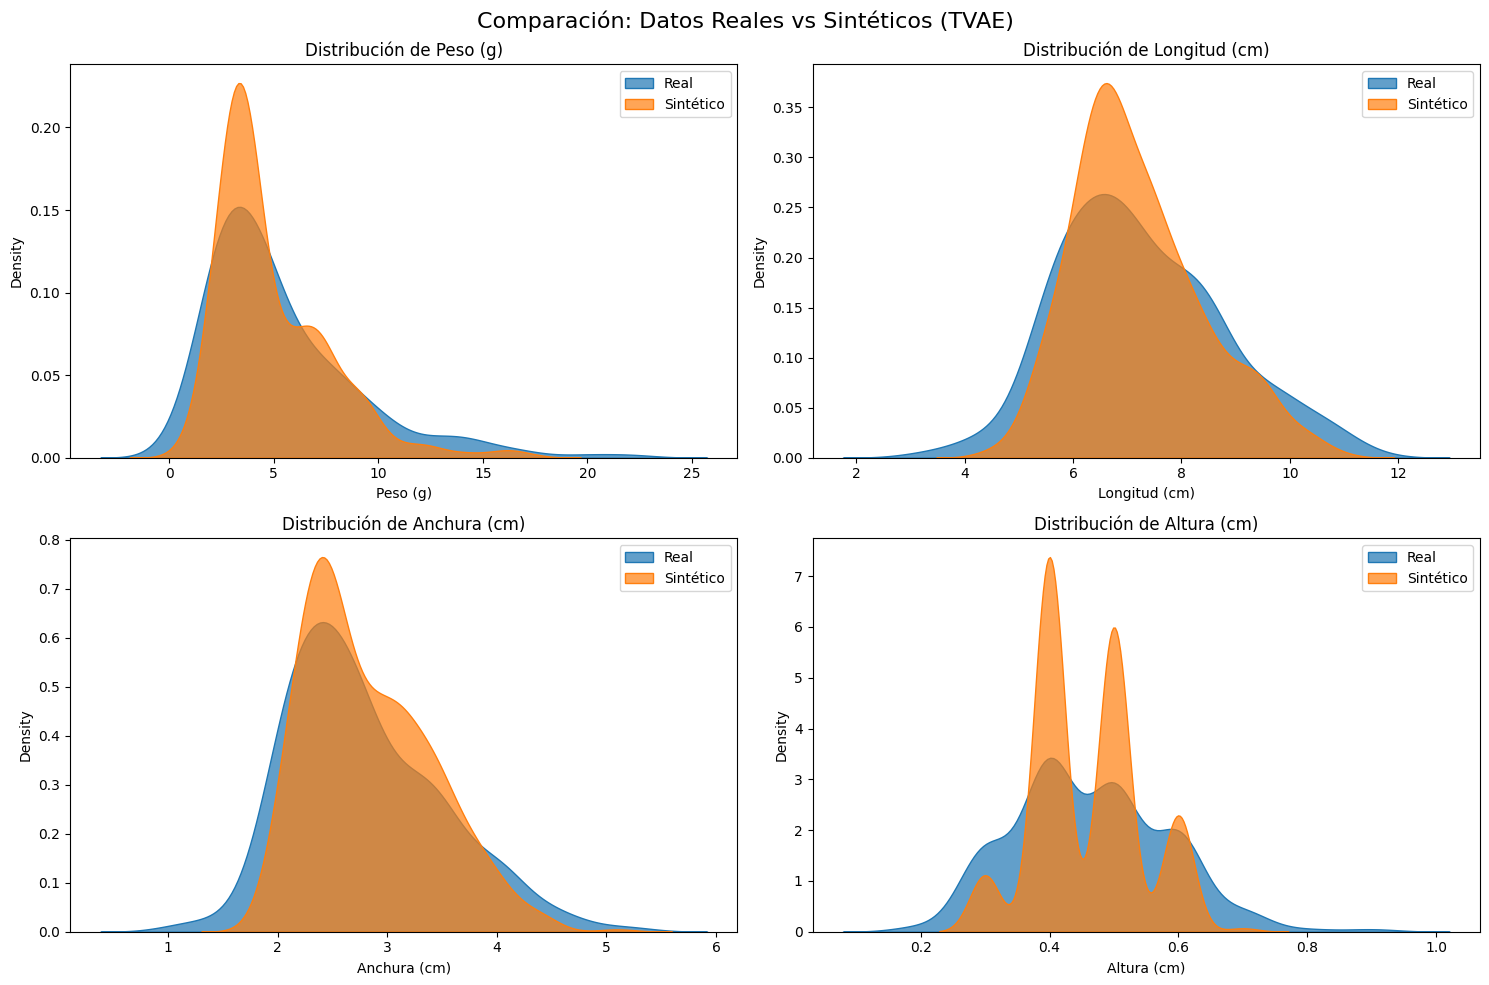


SIMILITUD ESTADÍSTICA

Overall score: 88.43%


 Distribuciones individuales real vs. sintética

          Column        Metric     Score
0       Peso (g)  KSComplement  0.899522
1  Longitud (cm)  KSComplement  0.899522
2   Anchura (cm)  KSComplement  0.909091
3    Altura (cm)  KSComplement  0.880383

 Correlaciones entre variables real vs. sintética

        Column 1       Column 2                 Metric     Score  \
0       Peso (g)  Longitud (cm)  CorrelationSimilarity  0.846520   
1       Peso (g)   Anchura (cm)  CorrelationSimilarity  0.832897   
2       Peso (g)    Altura (cm)  CorrelationSimilarity  0.923131   
3  Longitud (cm)   Anchura (cm)  CorrelationSimilarity  0.812543   
4  Longitud (cm)    Altura (cm)  CorrelationSimilarity  0.900099   
5   Anchura (cm)    Altura (cm)  CorrelationSimilarity  0.913511   

   Real Correlation  Synthetic Correlation  
0          0.932951               0.625991  
1          0.942354               0.608148  
2          0.861768               

In [6]:
import pandas as pd
import numpy as np
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import Metadata
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from myst_nb import glue

num_synthetic = 500 #variable para definir el número de registros sintéticos

# 1. Cargar datos reales
#--------------------------
path_realData = '.././data/Dimensiones_lenguado.xlsx'  
real_data = pd.read_excel(path_realData)

# 2. Obtener los metadata del dataset
#--------------------------------------

metadata_path = Path('.././data/metadata_lenguado.json')

if metadata_path.exists():
    # Cargar metadatos desde el JSON (evita el warning)
    metadata = Metadata.load_from_json(metadata_path)
    print("Metadatos cargados desde JSON.")
else:
    # Detectar metadatos y guardarlos en JSON para futuras ejecuciones
    metadata = Metadata.detect_from_dataframe(real_data)
    metadata.save_to_json(metadata_path)
    print("Metadatos detectados y guardados en JSON.")

# 3. Inicializar y entrenar TVAE
#--------------------------------
print("Inicializando TVAE...")
tvae_model = TVAESynthesizer(
    metadata = metadata,
    epochs=300,           # Número de épocas de entrenamiento
    batch_size=32,        # Tamaño del batch
    embedding_dim=128,    # Dimensión del espacio latente
    compress_dims=(128, 128),  # Capas del encoder
    decompress_dims=(128, 128), # Capas del decoder
    loss_factor=2,        # Balance entre pérdida de reconstrucción y KL
    cuda=True             # Usar GPU si está disponible
)

print("Entrenando TVAE (esto puede tomar varios minutos)...")
tvae_model.fit(real_data)

# 4. Generar datos sintéticos
#-----------------------------
print("Generando datos sintéticos...")
syntheticTVAE_data = tvae_model.sample(num_rows=500);
display(syntheticTVAE_data.head(10))
print(f"Se muestran 10 primeros registros sintéticos TVAE de un total de {num_synthetic}")

# 5. Guardar resultados
#-------------------------
path_syntheticTVAEData = ".././data/SyntheticTVAE.xlsx"
syntheticTVAE_data.to_excel(path_syntheticTVAEData, index=False, engine='openpyxl')

# 6. Evaluación datos sintéticos
#-------------------------------

## Diagnóstico básico
diagnosticTVAE = run_diagnostic(real_data, syntheticTVAE_data, metadata, False) 
print("\nDIAGNÓSTICO BÁSICO CALIDAD DATOS\n")
print(diagnosticTVAE.get_details(property_name='Data Validity'))

## Visualización datos
#--------------------------------

columnas = ["Peso (g)", "Longitud (cm)", "Anchura (cm)", "Altura (cm)"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
variables = real_data.columns

for i, var in enumerate(variables):
    row, col = i // 2, i % 2
    sns.kdeplot(real_data[var], ax=axes[row, col], label='Real', fill=True, alpha=0.7)
    sns.kdeplot(syntheticTVAE_data[var], ax=axes[row, col], label='Sintético', fill=True, alpha=0.7)
    axes[row, col].set_title(f'Distribución de {var}')
    axes[row, col].legend()

plt.suptitle('Comparación: Datos Reales vs Sintéticos (TVAE)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


## Medidas de similiud estadística

quality_reportTVAE = evaluate_quality(real_data, syntheticTVAE_data.sample(n=len(real_data), random_state=42), metadata, False)

## Obtenemos el valor promedio de la similitud
overall_scoreTVAE = f"{quality_reportTVAE.get_score()*100:.2f}%"
glue("scoreTVAE", overall_scoreTVAE, display=False); # Definimos una variable para usar en el texto markdown
print("\nSIMILITUD ESTADÍSTICA\n")
print(f"Overall score: {overall_scoreTVAE}\n")

print("\n Distribuciones individuales real vs. sintética\n")
print(quality_reportTVAE.get_details('Column Shapes'))

print("\n Correlaciones entre variables real vs. sintética\n")
print(quality_reportTVAE.get_details('Column Pair Trends'))

En líneas generales, este método proporciona una similud estadística general del {glue:}`scoreTVAE`. Un análisis con mayor detalle nos revela que la generación de datos sintéticos a nivel de variable individual mantiene razonablemente bien las características originales ($\approx 90\%$). Por otro lado, la métrica `CorrelationSimilarity` entre pares de variables es elevada aunque inferior al método Gaussian Copula. En lo que se refiere a las correlaciones sintéticas entre variables, los valores porcentuales son bastante menores que los correspondientes referencias con datos reales, lo cual sugiere que los datos obtenidos pueden no ser válidos para entrenamiento de algoritmos de *machine learning*.